# Guided Capstone Step 6 - Answer Key

**The Data Science Method**  


1.   Problem Identification 


2.   Data Wrangling 
  
 
3.   Exploratory Data Analysis   

4.   Pre-processing and Training Data Development  
 * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
5.   **Modeling** 
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   **Documentation**
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

**<font color='DarkBlue'> Start by loading the necessary packages as we did in previous steps and printing out our current working directory just to confirm we are in the correct project directory. </font>**

In [ ]:
import os
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import json
%matplotlib inline
import plotly.graph_objects as go 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error
from math import sqrt
from sklearn.metrics import explained_variance_score

**<font color='DarkBlue'> Print the list of files in the current working directory to confirm you are in the correct project directory. </font>**

In [ ]:
os.listdir()

['.ipynb_checkpoints',
 'COVID19_GuidedCapstoneSteps_1_and_2_noapi_answerkey.ipynb',
 'COVID19_GuidedCapstoneStep6_AnswerKey.ipynb',
 'COVID19_GuidedCapstoneStep4andStep5_AnswerKey.ipynb',
 'COVID19_GuidedCapstoneStep3_AnswerKey.ipynb']

**<font color='DarkBlue'> If you need to change your path refer back to the notebook on steps 1 & 2 on how to do that. Then load the csv file remember it should be saved inside your data subfolder and print the first five rows.</font>**

In [ ]:
file='https://raw.githubusercontent.com/AVJdataminer/COVID19_GC/master/data/1590861594.6363733.csv'
df_confirmed=pd.read_csv(file)
df_confirmed.head()

### Create timeseries data, select only date and confirmed cases from the training data.

In [ ]:
#create timeseries data, so only date and confirmed cases data frame.
df_confirmed = df_confirmed[df_confirmed['country_region']=='US']
cdf = df_confirmed[['timestamp.date', 'confirmed']]
cdf['date'] = pd.to_datetime(cdf['timestamp.date'])
cdf.sort_values(by ='date', inplace=True,ascending =True)
cdf = cdf.drop('timestamp.date', axis =1)
cdf.set_index('date', inplace = True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [ ]:
cdf.head()

,confirmed
date,
2020-03-15,3499
2020-03-16,4632
2020-03-17,6421
2020-03-18,7783
2020-03-19,13677


In [ ]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2020-03-15 to 2020-05-29
Data columns (total 2 columns):
timestamp.date    61 non-null object
confirmed         61 non-null object
dtypes: object(2)
memory usage: 1.4+ KB


Resample the data as daily timeseries, using a`asfreq('D')` 

In [ ]:
cdf = cdf.asfreq('D')
cdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2020-03-15 to 2020-05-29
Freq: D
Data columns (total 1 columns):
confirmed    61 non-null object
dtypes: object(1)
memory usage: 1.2+ KB


In [ ]:
cdf.isnull().sum()

confirmed    15
dtype: int64

Notice the size now changed to 76 entries. The reason for this is that some dates in our time frame had no reported confirmed cases, these are probably weekends and holidays.

Now we need to fill the Nan values from the additional dates. We will use a linear interpolation to fill the null values. First we need to set the column to numeric.

In [ ]:
cdf['confirmed'] = pd.to_numeric(cdf['confirmed'])
cdf = cdf.interpolate(method='linear', limit_direction='forward')
cdf.head()

,confirmed
date,
2020-03-15,3499.0
2020-03-16,4632.0
2020-03-17,6421.0
2020-03-18,7783.0
2020-03-19,13677.0


## Split into training and testing datasets

**<font color='DarkBlue'> Split the data into training and testing data subset based on the order the data is sorted in.</font>** 

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(cdf, test_size=0.2, shuffle=False)

In [ ]:
df_test.shape

(16, 1)

## Model Confirmed cases with ARIMA

In the last notebook we compared three different ARIMA models and based on the AIC values selected one of the models to use.

**<font color='DarkBlue'> Fit the best ARIMA model as we did in the step four and five notebook. </font>**

In [ ]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

Build a third model with different parameters.

In [ ]:
p=1
d=2
q=1
model = ARIMA(df_train, order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.confirmed   No. Observations:                   58
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -568.405
Method:                       css-mle   S.D. of innovations           4352.241
Date:                Sat, 30 May 2020   AIC                           1144.809
Time:                        19:43:17   BIC                           1153.051
Sample:                    03-17-2020   HQIC                          1148.019
                         - 05-13-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                353.6625    322.630      1.096      0.278    -278.681     986.006
ar.L1.D2.confirmed    -0.2642      0.276     -0.956      0.343      -0.806       0.278
ma.L1.D2.confirmed    -0.2940      0.288     -1.020      0.312      -0.859       0.271
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.7847           +0.0000j            3.7847            0.5000
MA.1            3.4011           +0.0000j            3.4011            0.0000
-----------------------------------------------------------------------------
"""

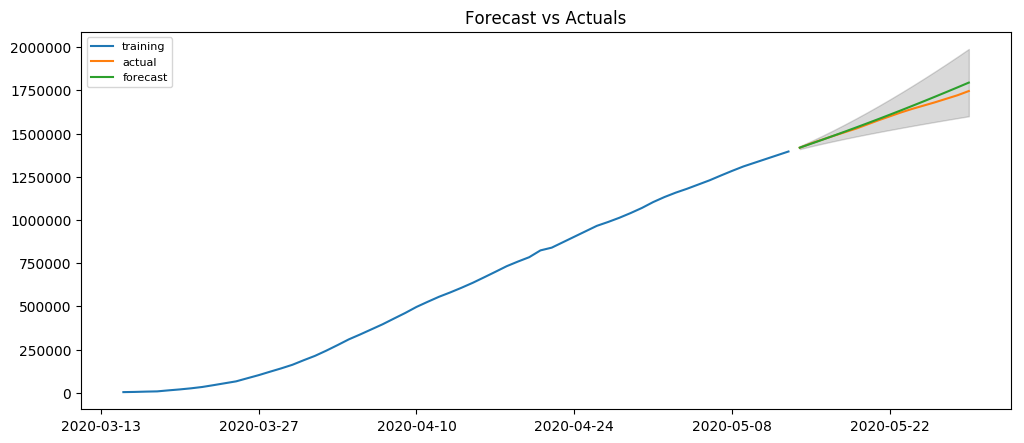

In [ ]:
# Forecast
fc, se, conf = model_fit.forecast(16, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    accuracy = 100 - np.mean(mape)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax, 'accuracy':accuracy})

forecast_accuracy(fc, df_test['confirmed'].values)

{'mape': 0.009578894037522923,
 'me': 15734.670501095025,
 'mae': 16045.880791781834,
 'mpe': 0.00936415728677182,
 'rmse': 22804.813617452273,
 'corr': 0.9985710319198426,
 'minmax': 0.009404045151422125,
 'accuracy': 99.99042110596248}

## Forecast 60 days out from end of training data

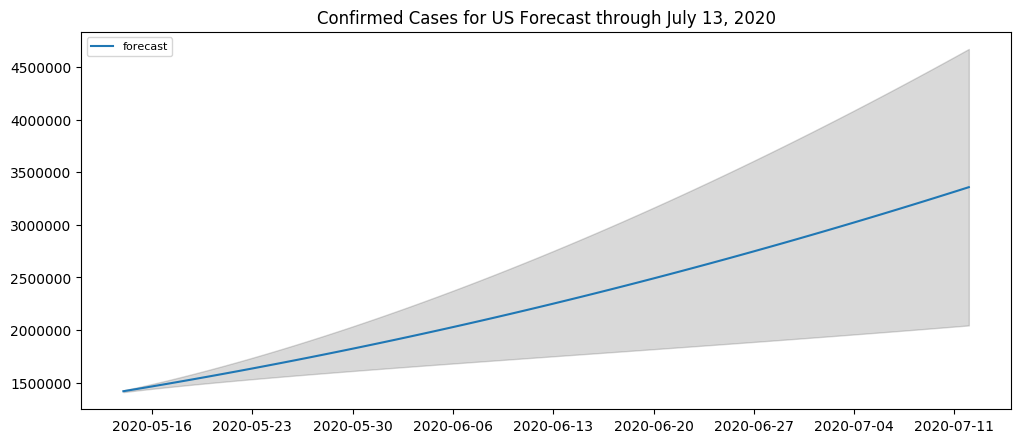

In [ ]:
#forecast for another 60 days
# Forecast
fc, se, conf = model_fit.forecast(60, alpha=0.05)  # 95% conf
#create 60 day index for plotting
rng = pd.date_range(start='2020-05-14', end='2020-07-12', freq='D')
# Make as pandas series
fc_series = pd.Series(fc, index=rng)
lower_series = pd.Series(conf[:, 0], index=rng)
upper_series = pd.Series(conf[:, 1], index=rng)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Confirmed Cases for US Forecast through July 13, 2020')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
df_60 = pd.DataFrame(fc, index=rng)
df_60.tail()

,0
2020-07-08,3.187855e+06
2020-07-09,3.229928e+06
2020-07-10,3.272355e+06
2020-07-11,3.315136e+06
2020-07-12,3.358270e+06


# Compare to Deaths

In [ ]:
#create timeseries data, so only date and confirmed cases data frame.
df_confirmed = df_confirmed[df_confirmed['country_region']=='US']
cdf = df_confirmed[['timestamp.date', 'deaths']]
cdf['date'] = pd.to_datetime(cdf['timestamp.date'])
cdf.sort_values(by ='date', inplace=True,ascending =True)
cdf = cdf.drop('timestamp.date', axis =1)
cdf.set_index('date', inplace = True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [ ]:
cdf = cdf.asfreq('D')

In [ ]:
cdf['deaths'] = pd.to_numeric(cdf['deaths'])
cdf = cdf.interpolate(method='linear', limit_direction='forward')

In [ ]:
df_train, df_test = train_test_split(cdf, test_size=0.2, shuffle=False)

In [ ]:
p=1
d=2
q=1
model = ARIMA(df_train, order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D2.deaths   No. Observations:                   58
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -444.406
Method:                       css-mle   S.D. of innovations            513.182
Date:                Sat, 30 May 2020   AIC                            896.812
Time:                        20:45:02   BIC                            905.054
Sample:                    03-17-2020   HQIC                           900.023
                         - 05-13-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.8385     28.049      0.993      0.325     -27.136      82.813
ar.L1.D2.deaths     0.4776      0.181      2.638      0.011       0.123       0.833
ma.L1.D2.deaths    -0.7946      0.115     -6.908      0.000      -1.020      -0.569
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0937           +0.0000j            2.0937            0.0000
MA.1            1.2585           +0.0000j            1.2585            0.0000
-----------------------------------------------------------------------------
"""

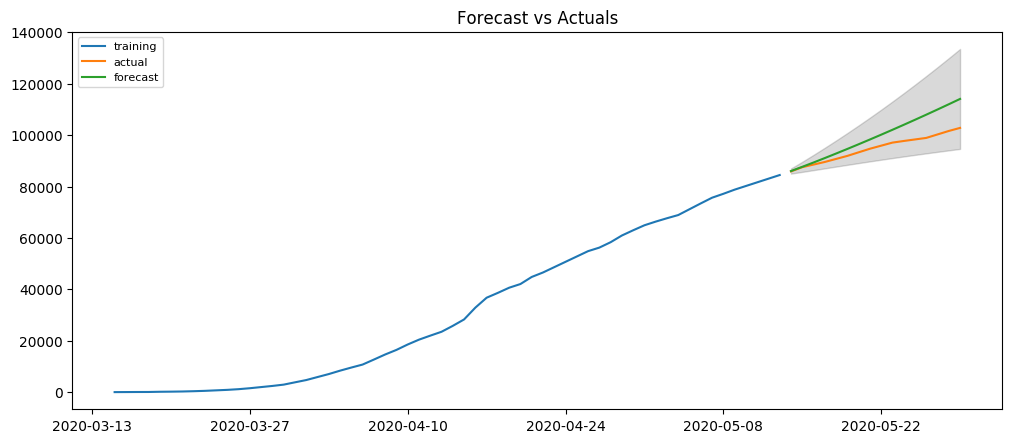

In [ ]:
# Forecast
fc, se, conf = model_fit.forecast(16, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
forecast_accuracy(fc, df_test['deaths'].values)

{'mape': 0.04943892316572175,
 'me': 4855.740835696191,
 'mae': 4855.740835696191,
 'mpe': 0.04943892316572175,
 'rmse': 6067.068503555011,
 'corr': 0.9945974010164587,
 'minmax': 0.04602709423413209,
 'accuracy': 99.95056107683428}

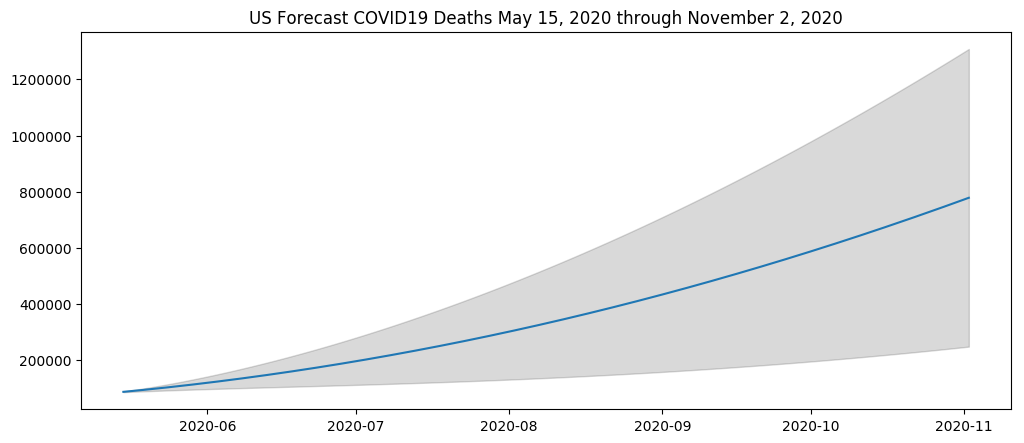

In [ ]:
#forecast until November 2
# Forecast
fc, se, conf = model_fit.forecast(172, alpha=0.05)  # 95% conf
#create 172 day index for plotting
rng = pd.date_range(start='2020-05-15', end='2020-11-02', freq='D')
# Make as pandas series
fc_series = pd.Series(fc, index=rng)
lower_series = pd.Series(conf[:, 0], index=rng)
upper_series = pd.Series(conf[:, 1], index=rng)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('US Forecast COVID19 Deaths May 15, 2020 through November 2, 2020')
plt.show()

Summarizing the forecasted deaths.

In [ ]:
print('Forecast US deaths count for 11/2/2020: '+ str(round(fc_series[-1],2)))
print('Forecast US deaths high count for 11/2/2020: '+ str(round(upper_series[-1],2)))
print('Forecast US deaths low count for 11/2/2020: '+ str(round(lower_series[-1],2)))

Forecast US deaths count for 11/2/2020: 777956.52
Forecast US deaths high count for 11/2/2020: 1308640.94
Forecast US deaths low count for 11/2/2020: 247272.11


Forecast for 365 days out.

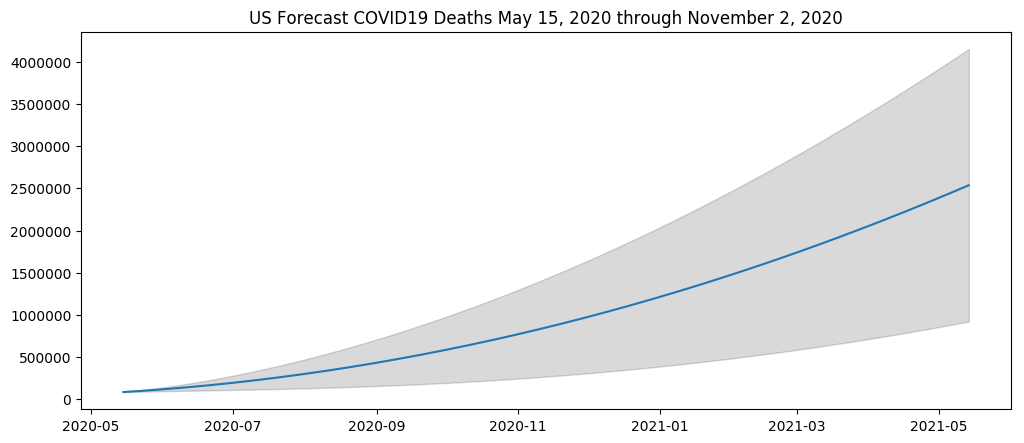

In [ ]:
#forecast for 365 out
# Forecast
fc, se, conf = model_fit.forecast(365, alpha=0.05)  # 95% conf
#create index for plotting
rng = pd.date_range(start='2020-05-15', end='2021-05-14', freq='D')
# Make as pandas series
fc_series = pd.Series(fc, index=rng)
lower_series = pd.Series(conf[:, 0], index=rng)
upper_series = pd.Series(conf[:, 1], index=rng)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('US Forecast COVID19 Deaths May 15, 2020 through May 15, 2021')
plt.show()

In [ ]:
print('Forecast US deaths count for 05/15/2021: '+ str(round(fc_series[-1],2)))
print('Forecast US deaths high count for 05/15/2021: '+ str(round(upper_series[-1],2)))
print('Forecast US deaths low count for 05/15/2021: '+ str(round(lower_series[-1],2)))

Forecast US deaths count for 05/15/2021: 2536855.7
Forecast US deaths high count for 05/15/2021: 4151852.42
Forecast US deaths low count for 05/15/2021: 921858.98
